In [1]:
import warnings

warnings.filterwarnings("ignore")

from tqdm.auto import tqdm
import matplotlib.pyplot as plt
from scipy.stats import mannwhitneyu, ttest_ind, t

import numpy as np
import pandas as pd
from scipy import stats

# Семинар 0: Мини-вводная в статистические гипотезы


Пусть мы работаем в онлайн магазине по продаже цветов. Цель любого магазина – зарабатывать деньги.

Чтобы наш магазин радовал покупателей, оставался конкурентным на рынке, а еще и зарабатывал деньги, нужно всего лишь...
Разрабатывать нужное и не разрабатывать ненужное. А как понять, что фича нужная? Нужно как-то учитывать интересы компании и наших пользователей.

Часто на помощь приходят методы статистики.

## 1. Зачем нам вообще статистика в продукте?

Наш дизайнер предложил сделать новую карточка букета: с крупной фотографией, видимыми отзывами и подсказкой “успеть к завтрашней доставке”. Гипотеза – товар с новой карточкой чаще будут покупать, ведь описание такое классное.

Как проверить такую гипотезу? Наивные варианты
1. Выкатить на всех и сравнить до / после
2. Выкатить на часть лояльных пользователей и сравнить, может они действительно чаще будут покупать?

Но мы, конечно, уже знаем, что кроме нашей новой карточки на вероятность покупки влияет множество факторов. И чтобы честно оценить эффект от нашей карточки, нужно соблюсти множество предпосылок.

Допустим, мы все уже знаем, правильно провели эксперимент и получили эффект: за 2 недели теста конверсия выросла на +3%.
Наш главный вопрос - это много или мало? В целом, уже можно сказать, что "мы выросли, все супер". Но доказательной базы для обоснованных продуктовых решений здесь, конечно, недостаточно.

По сути, наша задача сводится к следующим пунктам:
- определить продуктовую гипотезу
- засетапить эксперимент, получить "две реальности"
- научиться интерпретировать результаты: честно ли мы провели тест, полученная разница является случайной или системной, вызванной нашей новой карточкой товара?

## 2. Формальная постановка: наблюдаемая величина и шум
В онлайн-экспериментах метрика, которую мы измеряем, — не фиксированное число, а реализация случайного процесса.
Один и тот же продукт при одном и том же истинном параметре может давать разные наблюдения.

Мы продолжаем говорить про магазин цветов и формулируем продуктовую гипотезу:
> Новый дизайн лучше старого, то есть конверсия в покупку вырастет

Переложим в термины статистики


Пусть пользователь либо добавляет букет в корзину, либо нет. Исхода всего два — удобно моделировать через случайную величину:

$$
X \sim \mathrm{Bernoulli}(p)
$$

где $p$ — истинная вероятность конверсии.

Для $n$ независимых пользователей получаем $n$ испытаний, то есть биномиальное распределение с параметрами $n$ и $p$:

$$
S = \sum_{i=1}^{n} X_i \sim \mathrm{Binomial}(n, p)
$$

А наблюдаемая конверсия:

$$
\hat{p} = 
\frac{S}{n}
$$

Простая симуляция. Пусть у нас 10000 пользователей и в старой карточке конверсия в покупку была 5%. 
Визуализируем наше распределение. 

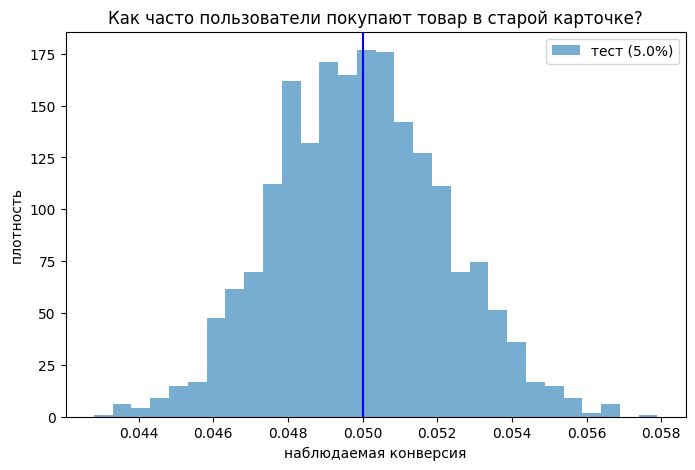

In [60]:
# число пользователей
n = 10000
# конверсия в старой и новой карточке
p_A = 0.05
trials = 2000  # количество прогонов эксперимента

conv_A = np.random.binomial(n, p_A, size=trials) / n

plt.figure(figsize=(8, 5))
plt.hist(conv_A, bins=30, alpha=0.6, density=True, label=f"тест ({p_A * 100}%)")
plt.axvline(p_A, color="blue")
plt.xlabel("наблюдаемая конверсия")
plt.ylabel("плотность")
plt.title("Как часто пользователи покупают товар в старой карточке?")
plt.legend()
plt.show()

## 3. Гипотезы в статистике

### 3.1 Как формулировать гипотезы?
Тестируем новую карточку букета.  
Метрика — конверсия в покупку: купил букет или нет.

Продуктовая гипотеза:
 > Новый дизайн лучше старого, то есть конверсия в покупку вырастет

Переложим ее в термины статистики. Очень важно сделать это правильно, чтобы не наделать ошибок в эксперименте. Пусть:

- $p_{1}$ — конверсия при старой карточке (контроль)
- $p_{2}$ — конверсия при новой карточке (тест)

Формализуем задачу:

**Нулевая гипотеза (мир без эффекта):**

$$
H_{0}: p_{1} = p_{2}
$$

В словах: новая карточка не меняет вероятность покупки.

**Альтернативная гипотеза (мир с эффектом):**

- двусторонняя:
$$
H_{1}: p_{1} \neq p_{2}
$$

- односторонняя на улучшение:
$$
H_{1}: p_{2} > p_{1}
$$

В нашем примере рассматриваем одностороннюю гипотезу на улучшение, ведь ожидаем, что новый дизайн реально улучшит конверсию и отклонение в другую сторону нас не интересует.

Иллюстрация через симуляцию, пусть наша карточка улучшила конверсию на +1% в абсолюте. Мы видим, что две смоделированные реальности действительно отличаются, но есть и пересечение. Наша ключевая задача состоит в том, чтобы определить, когда мы скажем, что изменение значимое.

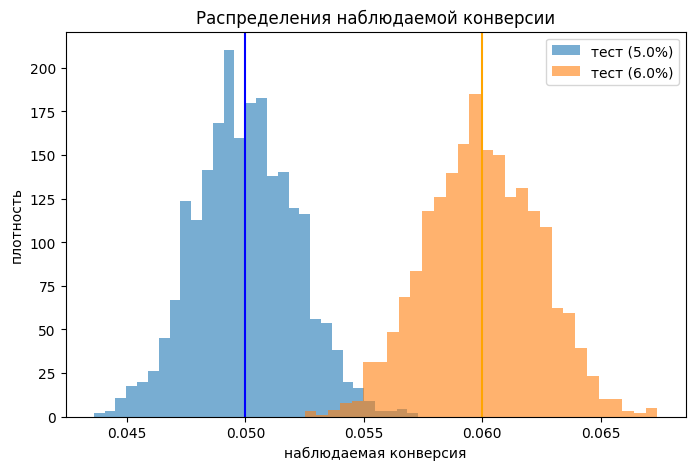

In [61]:
# число пользователей
n = 10000
# конверсия в старой и новой карточке
p_A = 0.05
p_B = 0.06
trials = 2000  # количество прогонов эксперимента

conv_A = np.random.binomial(n, p_A, size=trials) / n
conv_B = np.random.binomial(n, p_B, size=trials) / n

plt.figure(figsize=(8, 5))
plt.hist(conv_A, bins=30, alpha=0.6, density=True, label=f"тест ({p_A * 100}%)")
plt.hist(conv_B, bins=30, alpha=0.6, density=True, label=f"тест ({p_B * 100}%)")
plt.axvline(p_A, color="blue")
plt.axvline(p_B, color="orange")
plt.xlabel("наблюдаемая конверсия")
plt.ylabel("плотность")
plt.title("Распределения наблюдаемой конверсии")
plt.legend()
plt.show()

### 3.2. Что статистическая гипотеза *не* означает

Статистические гипотезы — это не утверждения о фактах, а **модели реальности**, с которыми мы работаем формально.

Важно:

- мы **не доказываем** $H_1$
- мы лишь решаем, есть ли основания **отвергнуть $H_0$**

После теста корректное утверждение звучит так:

> «Полученные данные маловероятны при $H_0$. Отвергаем $H_0$»

а не:

> «$H_1$ доказана»

Однако в прикладных задачах интерпретация эффекта, который мы посчитали значимым, опирается на **внешние знания о системе**. Например, если в нашем цветочном магазине в период эксперимента **не менялись цены, ассортимент, маркетинг и доставка**, а также не было внешних аномалий, то у нас есть предпосылки связывать рост конверсии с новой карточкой букета.

Еще один момент: $H_0$ всегда формулируется как **отрицательная модель** (“никакого эффекта нет”). Почему? потому что именно эту модель возможно описать математически. Как описать реальность, в которой $p_{2} > p_{1}$? Ведь мы могли улучшить конверсию до 10, 50% или вообще ее уронить. То есть существует бесконечное количество альтернативных реальностей и это куда сложнее, чем наша базовая знакомая реальность когда "эффекта нет".

## 4. Что такое статистический критерий

После формулировки гипотез и получения данных нам нужен формальный механизм, который решает: **отвергать H0 или нет**. Такой механизм называется статистическим критерием.

Определение в прикладном виде:

> Критерий — это алгоритм, который по данным принимает решение об отклонении или неотклонении H0 при **фиксированной вероятности ошибки первого рода ($\alpha$)** (альфа является параметром критерия)

### 4.1. Из чего состоит критерий

У любого критерия есть два ключевых элемента:

1. **тестовая статистика** — функция от данных
2. **критическая область** — область значений статистики, при попадании в которую критерий отвергает H0

Для примера возьмем что-то необычное, мы привыкли к стандартным статистикам. Но поскольку любая функция может быть статистикой, проиллюстрируем на примере функции `T = (кол-во покупок в тесте) - 2 * (кол-во покупок в контроле)`

Распределение нашей хитрой статистики:

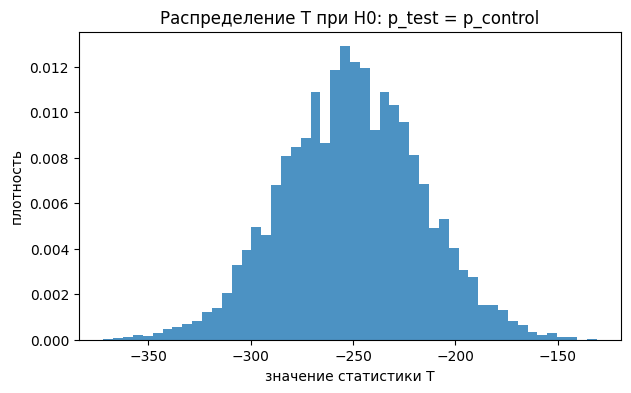

In [76]:
n = 5000
p = 0.05
trials = 10000

data = []

for _ in range(trials):
    control = np.random.binomial(1, p, size=n)
    test = np.random.binomial(1, p, size=n)
    T = test.sum() - 2 * control.sum()
    data.append(T)

plt.figure(figsize=(7, 4))
plt.hist(data, bins=50, density=True, alpha=0.8)
plt.title("Распределение T при H0: p_test = p_control")
plt.xlabel("значение статистики T")
plt.ylabel("плотность")
plt.show()

### 4.2. Определение критической области

Как определить критическую область? Это значения, которые при верности $H0$ мы не встретим чаще чем в $\alpha$% случаев. Как это посчитать? Правильно, через **квантиль**
>  Квантиль — это значение, ниже которого лежит заданная доля данных. Например, 90-й квантиль — это число, выше которого только 10% наблюдений. То есть $P(T \le x_{1-\alpha}) = 1-\alpha$, где $x_{1}$ – граница критической области. Число, при попадании в которое (или правее/левее, экстремальнее) мы считаем, что конверсия в покупку значимо выросла.

Посчитаем квантиль нашей хитрой статистики

In [77]:
# уровень значимости
alpha = 0.05

# критическое значение (граница критической области)
crit = np.quantile(data, 1 - alpha)
crit

np.float64(-195.0)

Визуализируем на графике распределения

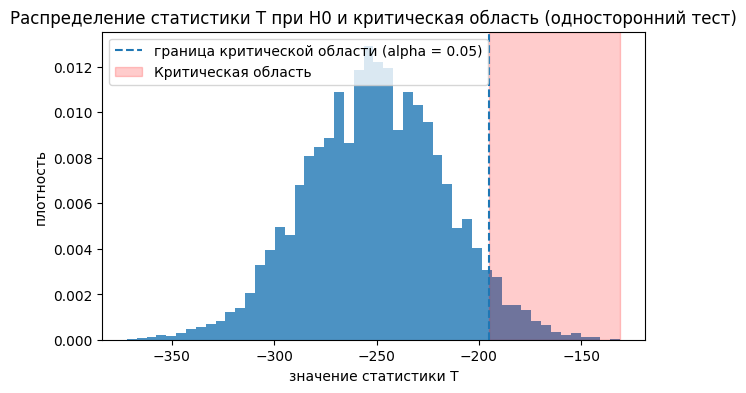

In [78]:
plt.figure(figsize=(7, 4))
plt.hist(data, bins=50, density=True, alpha=0.8)

# вертикальная линия — граница критической области
plt.axvline(
    crit, linestyle="--", label=f"граница критической области (alpha = {alpha})"
)

# закраска критической области
plt.axvspan(crit, max(data), alpha=0.2, color="red", label="Критическая область")

plt.title(
    "Распределение статистики T при H0 и критическая область (односторонний тест)"
)
plt.xlabel("значение статистики T")
plt.ylabel("плотность")
plt.legend()
plt.show()

Если в реальности наблюдаемое значение статистики получилось > -194, значит, новый дизайн улучшает конверсию.

Еще раз осознаем механику:
- придумали статистику
- знаем ее распределение
- считаем $1 - \alpha$ квантиль для односторонней гипотезы. Именно за этим значениями лежит $\alpha$% самых экстремальных значений, которые совсем маловероятны в реальности $H_0$, где эффекта нет
- если попали в критическую область, отвергаем $H_0$

Вопрос – как будет задаваться крит область для двусторонней гипотезы?

### 4.3. Биномиальный критерий - практика

Но мы знаем, что лучше использовать биномиальный критерий, потому что сравниваем конверсии. А число успехов (купил или нет) в реальности описывается биномиальным законом.

Пусть:

- n — число пользователей в группе
- X — число покупок
- p0 — конверсия при нулевой гипотезе

При H0 предполагается что p равен p0, тогда из тервера мы знаем,

`X имеет биномиальное распределение Binomial(n, p0)`

Давайте потренируемся и найдем критические значения для нашего примера с цветами. 
Упростим вводные, чтобы не делать сложных вычислений:
- число пользователей - `100`
- наблюдаемая конверсия в покупку - `0.1`, то есть `X_obs = 10`

Введем функции для формулы Бернулли и `P(X >= k)`

In [3]:
from math import comb


def bernoulli_pmf(k, n, p):
    """
    Вероятность P(X = k) для X ~ Binomial(n, p)
    """
    return comb(n, k) * (p**k) * ((1 - p) ** (n - k))


# 1
# def bernoulli_pmf(k, n, p):
#     """
#     Вероятность P(X = k) для X ~ Binomial(n, p)
#     Используем число сочетаний + вероятности в степенях, просто кодим формулу Бернулли
#     """
#     return  comb(n, k) * (p  k) * ((1 - p)  (n - k))


# 2
# math.comb(n, k) * (p ^ k) ^ (1 - p) ^ (n - k)?


def binomial_tail(k, n, p):
    """
    P(X >= k) для X ~ Binomial(n, p)
    """
    return sum(bernoulli_pmf(i, n, p) for i in range(k, n + 1))

Теперь задача – найти критические значения, где мы отвергнем нулевую гипотезу и посчитаем, что новая карточка улучшила дизайн

In [7]:
p0 = 0.1  # конверсия при H0
n = 100  # число пользователей
alpha = 0.05  # уровень значимости

## TO DO - найти критическое значение используя функции выше
for k in range(10, n + 1):
    а = binomial_tail(k, n, p0)
    if а <= alpha:
        k_crit = k
        break

print(k_crit)

16


In [5]:
p0 = 0.1  # конверсия при H0
n = 100  # число пользователей
alpha = 0.05  # уровень значимости

## TO DO - найти критическое значение используя функции выше
# мат ожидание при H0
k_star = int(n * p0)
while binomial_tail(k_star, n, p0) > alpha:
    k_star += 1
    print(
        f"Значение: {k_star}, вероятность попасть в него или правее: {binomial_tail(k_star, n, p0)}"
    )

Значение: 11, вероятность попасть в него или правее: 0.41684448773350935
Значение: 12, вероятность попасть в него или правее: 0.296966899711247
Значение: 13, вероятность попасть в него или правее: 0.19817888735956787
Значение: 14, вероятность попасть в него или правее: 0.12387679259933056
Значение: 15, вероятность попасть в него или правее: 0.07257296526488097
Значение: 16, вероятность попасть в него или правее: 0.039890527111083464


Аналогичная штука через встроенные методы – используем CDF - кумулятивную функцию распределения. Находим `1 - P(X >= k)`

Критическое значение k* = 16
P(X >= k* | H0) = 0.0399


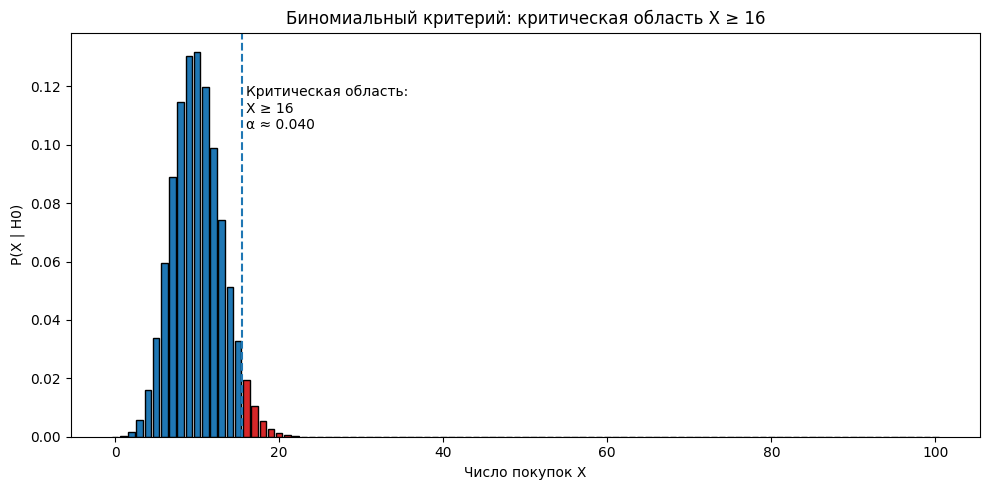

In [8]:
from scipy.stats import binom

# Все возможные значения X
x = np.arange(0, n + 1)
pmf = binom.pmf(x, n, p0)

# 1. Находим критическое значение k_star
tail_probs = 1 - binom.cdf(x - 1, n, p0)  # P(X >= x)
k_star = x[tail_probs <= alpha][0]

print(f"Критическое значение k* = {k_star}")
print(f"P(X >= k* | H0) = {tail_probs[x == k_star][0]:.4f}")

# 2. Строим график биномиального распределения
colors = ["tab:blue" if xi < k_star else "tab:red" for xi in x]

plt.figure(figsize=(10, 5))
plt.bar(x, pmf, color=colors, edgecolor="black")

# Вертикальная линия по границе критической области
plt.axvline(k_star - 0.5, linestyle="--")

# Подписи
plt.title(f"Биномиальный критерий: критическая область X ≥ {k_star}")
plt.xlabel("Число покупок X")
plt.ylabel("P(X | H0)")

# Текст с уровнем значимости
plt.text(
    k_star,
    max(pmf) * 0.8,
    f"Критическая область:\nX ≥ {k_star}\nα ≈ {tail_probs[x == k_star][0]:.3f}",
    fontsize=10,
)

plt.tight_layout()
plt.show()

Вопрос – почему мы получаем $\alpha \neq 0.05$?

### 4.4. P-value – универсальный метод

В биномиальном критерии мы строили **критическую область** напрямую:  
фиксировали уровень значимости `alpha` и искали порог `k*`, начиная с которого результат считается слишком редким при H0.

Этот подход работает, но он привязан к конкретному распределению и форме критической области.  
Есть более универсальный способ формулировать решение — через **p-value**.

Пусть наблюдаем `X_obs` покупок в тесте

**p-value** — это:

> вероятность получить такое же или более экстремальное значение статистики,  
> если H0 верна

В биномиальном случае:

- статистика — число покупок `X`
- “более экстремальное” для теста на улучшение означает `X ≥ X_obs`

То есть:

`p-value = P(X ≥ X_obs | H0)`

**Как используется p-value?**

Правило принятия решения становится простым и универсальным:

- если `p-value ≤ alpha` → отвергаем H0
- если `p-value > alpha` → оснований отвергнуть H0 нет

Важный смысловой сдвиг:

- вместо поиска порога `k*` мы **оцениваем редкость конкретно наблюдаемого результата**
- один и тот же подход работает для разных статистик и распределений

На практике как правило используют этот метод.

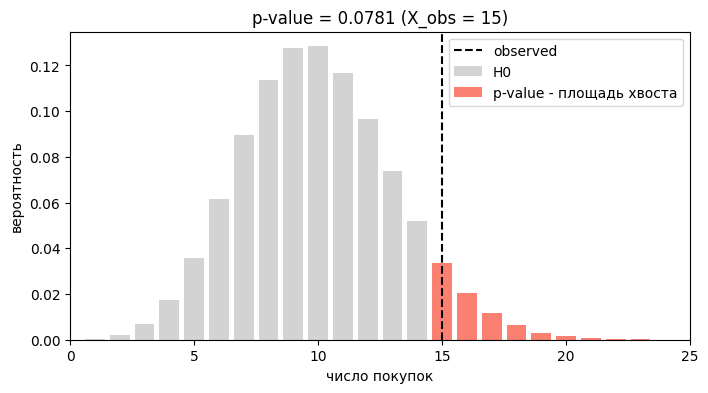

x_obs = 15, p-value = 0.0781


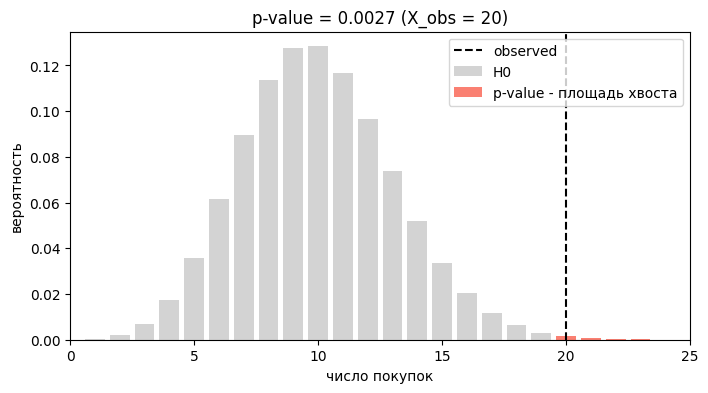

x_obs = 20, p-value = 0.0027


In [15]:
def plot_pvalue(p0, n, x_obs):
    """
    Визуализирует p-value как хвост биномиального распределения

    Parameters:
    p0 - вероятность при H0
    n - число пользователей
    x_obs - наблюдаемое число покупок
    """
    # распределение при H0
    ks = np.arange(0, n + 1)
    pmf = np.array([bernoulli_pmf(k, n, p0) for k in ks])

    # вычисляем p-value
    p_val = 1 - binom.cdf(x_obs - 1, n, p0)

    plt.figure(figsize=(8, 4))

    # все распределение
    plt.bar(ks, pmf, color="lightgray", label="H0")

    # хвост = p-value
    mask = ks >= x_obs
    plt.bar(ks[mask], pmf[mask], color="salmon", label="p-value - площадь хвоста")

    # наблюдаемое значение
    plt.axvline(x_obs, color="black", linestyle="--", label="observed")
    plt.xlim([0, 25])

    plt.xlabel("число покупок")
    plt.ylabel("вероятность")
    plt.title(f"p-value = {p_val:.4f} (X_obs = {x_obs})")
    plt.legend()
    plt.show()

    print(f"x_obs = {x_obs}, p-value = {p_val:.4f}")


# Графики для x_obs = 15 и 20
plot_pvalue(p0=0.05, n=200, x_obs=15)
plot_pvalue(p0=0.05, n=200, x_obs=20)

Вопрос – мы разобрали биномиальный критерий для гипотезы о конверсии (или о доле). Но на практике чаще используют Z/T тест. Почему? Как связаны эти тесты?

## 5. Ошибки первого и второго рода

Мы помним, что на вход критерий получает вероятность $\alpha$ – вероятность, которая определит критическую область. Ок, что дальше делать?
Нужно подумать, как хорошо наш критерий будет работать на практике. А на практике мы можем совершить две ошибки:

- **ошибка первого рода (alpha):** отвергли H0, хотя она верна. Считаем, что карточка улучшила конверсию, хотя на самом деле нет. Ее же часто называют FPR – false positive rate 
  `FPR = P(reject H0 | H0 верна)`

- **ошибка второго рода (beta):** не отвергли H0, хотя верна H1. Считаем, что карточка не влияет на конверсию, хотя на самом деле пользователи от нее просто в восторге и стали чаще покупать.  
  `beta = P(not reject H0 | H1 верна)`

Как научиться их различать? Дефолтно считаем, что эффекта нет, то есть верна H0. Значит дефолтно мы совершаем ошибку первого рода, находим эффект, когда его нет.

Иногда вводят **мощность критерия**:

`power = 1 - beta`  
способность обнаруживать реальные эффекты.

| Истинное состояние | Решение | Что произошло |
|---|---|---|
| H0 | Reject | Ошибка первого рода (alpha) |
| H1 | Not reject | Ошибка второго рода (beta) |

Итого, для корректности и применения критерия на практике недостаточно “просто правила”.  
Необходимо, чтобы:

1. вероятность ложного сигнала (alpha) была заранее ограничена 
2. вероятность пропуска реального эффекта (beta) была приемлема (то есть power достаточно высок). При наличии нескольких валидных с точки зрения о1р критериев мы выберем тот, который **мощнее**. Позже разберем, как замерить мощность на практике, как правило через симуляции.



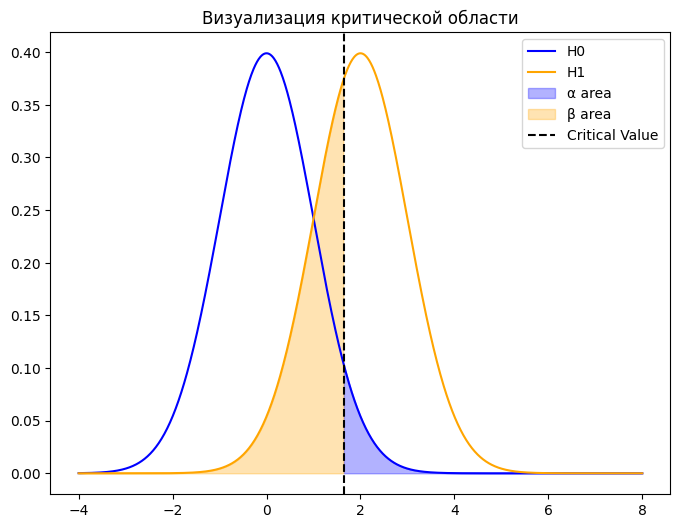

In [12]:
fig = plt.figure(figsize=(8, 6))
ax = fig.add_subplot(1, 1, 1)
x = np.linspace(-4, 8, 1000)
h0 = stats.norm.pdf(x, loc=0, scale=1)
h1 = stats.norm.pdf(x, loc=2, scale=1)
ax.plot(x, h0, label="H0", color="blue")
ax.plot(x, h1, label="H1", color="orange")
ax.fill_between(x, 0, h0, where=(x > 1.645), color="blue", alpha=0.3, label="α area")
ax.fill_between(x, 0, h1, where=(x < 1.645), color="orange", alpha=0.3, label="β area")
ax.axvline(1.645, color="black", linestyle="--", label="Critical Value")
ax.legend()
ax.set_title("Визуализация критической области")
plt.show()

## 6. Бонус - привыкаем к статистическим функциям в Python

Основные термины:

- `pmf` = probability mass function  
  Функция вероятности для дискретной случайной величины.  
  Возвращает $P(X = x)$ для заданного $x$.

- `cdf` = cumulative distribution function  
  Кумулятивная функция распределения.  
  Возвращает $P(X \le x)$.

- `rvs` = random variable sample  
  Генерация случайной выборки из заданного распределения.

- `ppf` = percent point function  
  Квантильная/перцентильная функция, обратная к `cdf`.  
  Возвращает такое $x$, что $P(X \le x) = q$.

- `sf` = survival function  
  Функция выживания.  
  Возвращает $P(X > x) = 1 - cdf(x)$.

Связь с тем, что уже разобрали:

- биномиальный хвост $P(X \ge k)$ — это `sf(k - 1)` или `1 - cdf(k - 1)` 
- p-value для одностороннего теста на улучшение — это `sf(X_obs - 1)`
- критическое значение $k^*$ можно искать как `ppf(1 - alpha)`

### 6.1 Дискретное распределение 

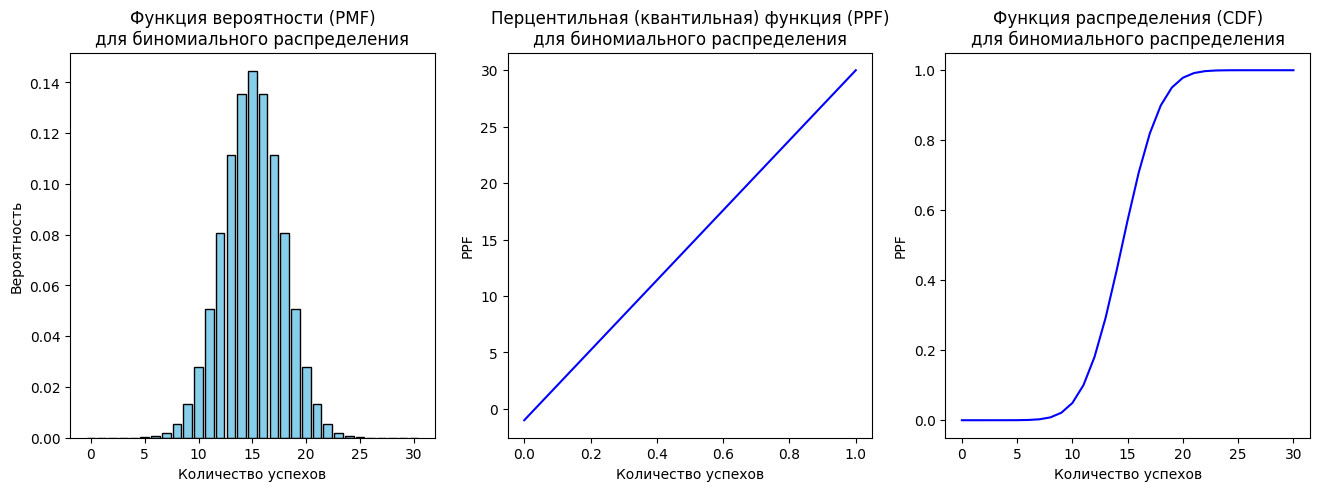

In [13]:
n, p = 30, 0.5  # количество испытаний и вероятность успеха
x = np.arange(0, n + 1)
# Вычисляем PMF и ppf
binom_pmf = stats.binom.pmf(x, n, p)
binom_ppf = stats.binom.ppf(x, n, p)
binom_cdf = stats.binom.cdf(x, n, p)

# Создаем подграфики
fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(16, 5))

# Подграфик 1: PMF
ax1.bar(x, binom_pmf, color="skyblue", edgecolor="black")
ax1.set_title("Функция вероятности (PMF)\nдля биномиального распределения")
ax1.set_xlabel("Количество успехов")
ax1.set_ylabel("Вероятность")

# Подграфик 2: ppF
ax2.plot(x, binom_ppf, color="blue")
ax2.set_title(
    "Перцентильная (квантильная) функция (PPF)\nдля биномиального распределения"
)
ax2.set_xlabel("Количество успехов")
ax2.set_ylabel("PPF")

# Подграфик 3: CDF
ax3.plot(x, binom_cdf, color="blue")
ax3.set_title("Функция распределения (CDF)\nдля биномиального распределения")
ax3.set_xlabel("Количество успехов")
ax3.set_ylabel("PPF")

plt.show()

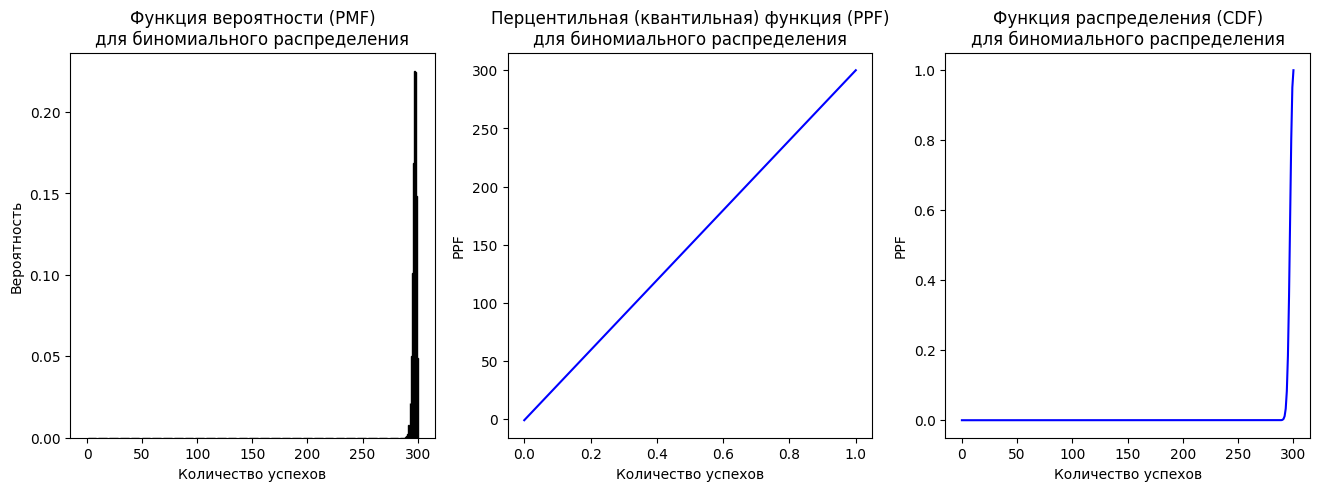

In [65]:
n, p = 300, 0.99  # количество испытаний и вероятность успеха
x = np.arange(0, n + 1)

# Вычисляем PMF и ppf
binom_pmf = stats.binom.pmf(x, n, p)
binom_ppf = stats.binom.ppf(x, n, p)
binom_cdf = stats.binom.cdf(x, n, p)

# Создаем подграфики
fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(16, 5))

# Подграфик 1: PMF
ax1.bar(x, binom_pmf, color="skyblue", edgecolor="black")
ax1.set_title("Функция вероятности (PMF)\nдля биномиального распределения")
ax1.set_xlabel("Количество успехов")
ax1.set_ylabel("Вероятность")

# Подграфик 2: ppF
ax2.plot(x, binom_ppf, color="blue")
ax2.set_title(
    "Перцентильная (квантильная) функция (PPF)\nдля биномиального распределения"
)
ax2.set_xlabel("Количество успехов")
ax2.set_ylabel("PPF")

# Подграфик 3: CDF
ax3.plot(x, binom_cdf, color="blue")
ax3.set_title("Функция распределения (CDF)\nдля биномиального распределения")
ax3.set_xlabel("Количество успехов")
ax3.set_ylabel("PPF")

plt.show()

In [66]:
# пример генерации семпла в нужном распределении
binom(n=n, p=p).rvs(10)

array([300, 297, 297, 294, 299, 298, 296, 295, 298, 299])

In [14]:
# получение вероятности p(X == x) через pmf
print(f"Вероятность 14 успехов в 30 испытаниях = {binom(n=n, p=p).pmf(14):.3f}")
print(f"Вероятность 15 успехов в 30 испытаниях = {binom(n=n, p=p).pmf(15):.3f}")
print(f"Вероятность 16 успехов в 30 испытаниях = {binom(n=n, p=p).pmf(16):.3f}")
print(f"Вероятность 17 успехов в 30 испытаниях = {binom(n=n, p=p).pmf(17):.3f}")
print(f"Вероятность 22 успехов в 30 испытаниях = {binom(n=n, p=p).pmf(22):.3f}")

Вероятность 14 успехов в 30 испытаниях = 0.135
Вероятность 15 успехов в 30 испытаниях = 0.144
Вероятность 16 успехов в 30 испытаниях = 0.135
Вероятность 17 успехов в 30 испытаниях = 0.112
Вероятность 22 успехов в 30 испытаниях = 0.005


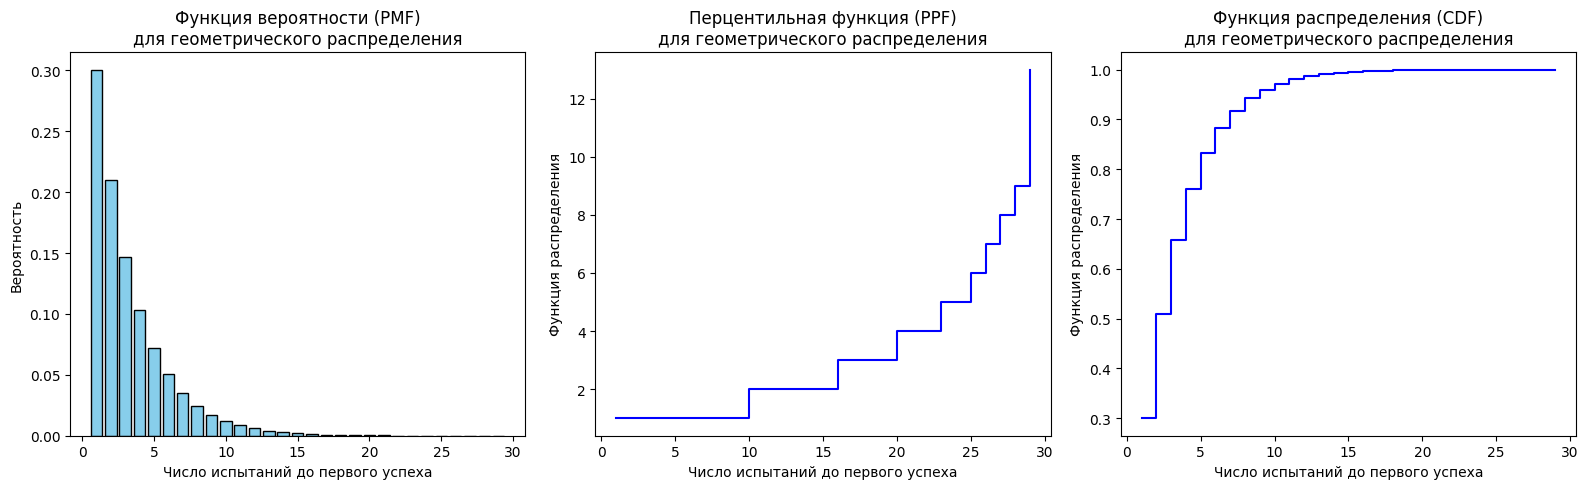

In [68]:
from scipy.stats import geom

p = 0.3  # вероятность успеха
x = np.arange(1, 30)  # возможные значения количества испытаний до первого успеха

geom_pmf = geom.pmf(x, p)
geom_ppf = geom.ppf(np.linspace(0.01, 0.99, len(x)), p)
geom_cdf = geom.cdf(x, p)

fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(16, 5))

ax1.bar(x, geom_pmf, color="skyblue", edgecolor="black")
ax1.set_title("Функция вероятности (PMF)\nдля геометрического распределения")
ax1.set_xlabel("Число испытаний до первого успеха")
ax1.set_ylabel("Вероятность")

ax2.step(x, geom_ppf, where="post", color="blue")
ax2.set_title("Перцентильная функция (PPF)\nдля геометрического распределения")
ax2.set_xlabel("Число испытаний до первого успеха")
ax2.set_ylabel("Функция распределения")

ax3.step(x, geom_cdf, where="post", color="blue")
ax3.set_title("Функция распределения (CDF)\nдля геометрического распределения")
ax3.set_xlabel("Число испытаний до первого успеха")
ax3.set_ylabel("Функция распределения")

plt.tight_layout()
plt.show()

In [69]:
# пример генерации семпла в нужном распределении
geom(p=p).rvs(10)

array([2, 2, 2, 1, 3, 8, 2, 4, 3, 1])

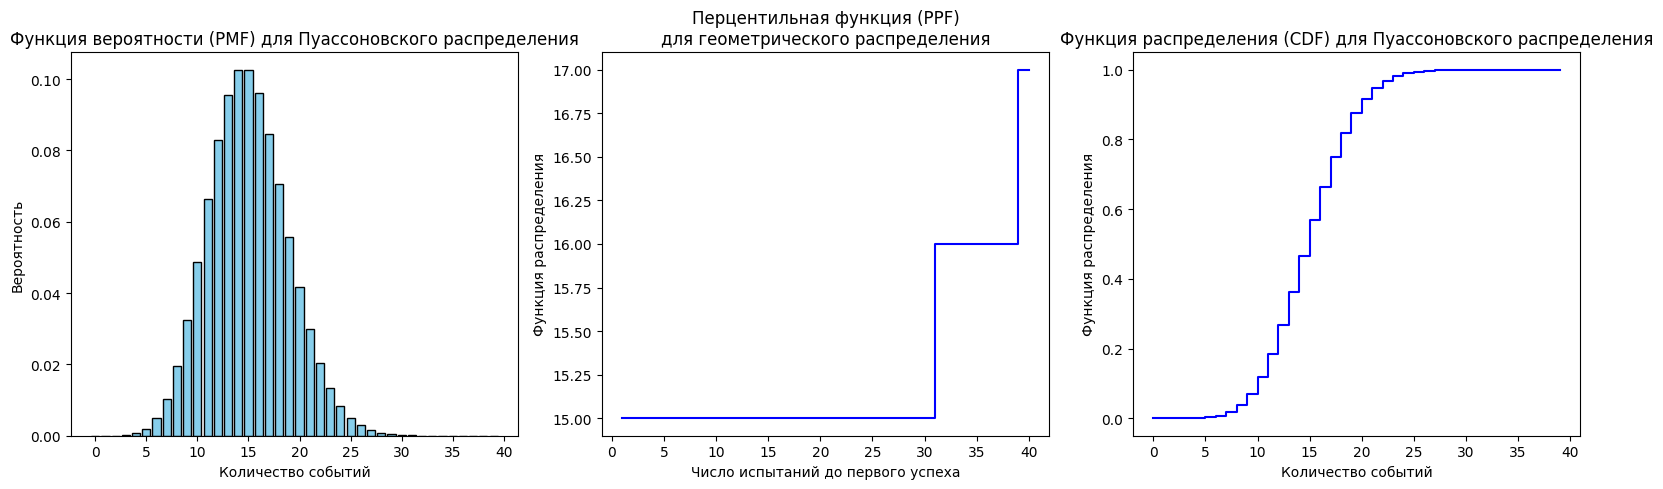

In [70]:
from scipy.stats import poisson

mu = 15  # среднее количество событий
x = np.arange(0, 40)  # значения для расчета вероятностей

poisson_pmf = poisson.pmf(x, mu)
poisson_ppf = poisson.ppf(np.linspace(0.01, 0.99, len(x)), p, mu)
poisson_cdf = poisson.cdf(x, mu)

# Создаем подграфики
fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(16, 5))

ax1.bar(x, poisson_pmf, color="skyblue", edgecolor="black")
ax1.set_title("Функция вероятности (PMF) для Пуассоновского распределения")
ax1.set_xlabel("Количество событий")
ax1.set_ylabel("Вероятность")

ax2.step(np.linspace(1, 40, len(poisson_ppf)), poisson_ppf, where="post", color="blue")
ax2.set_title("Перцентильная функция (PPF)\nдля геометрического распределения")
ax2.set_xlabel("Число испытаний до первого успеха")
ax2.set_ylabel("Функция распределения")

ax3.step(x, poisson_cdf, where="post", color="blue")
ax3.set_title("Функция распределения (CDF) для Пуассоновского распределения")
ax3.set_xlabel("Количество событий")
ax3.set_ylabel("Функция распределения")

plt.tight_layout()
plt.show()

In [71]:
# пример генерации семпла в нужном распределении
poisson(mu).rvs(10)

array([11, 12, 11, 20, 15, 19, 14, 11, 10, 21])

### 6.2 Непрерывное распределение

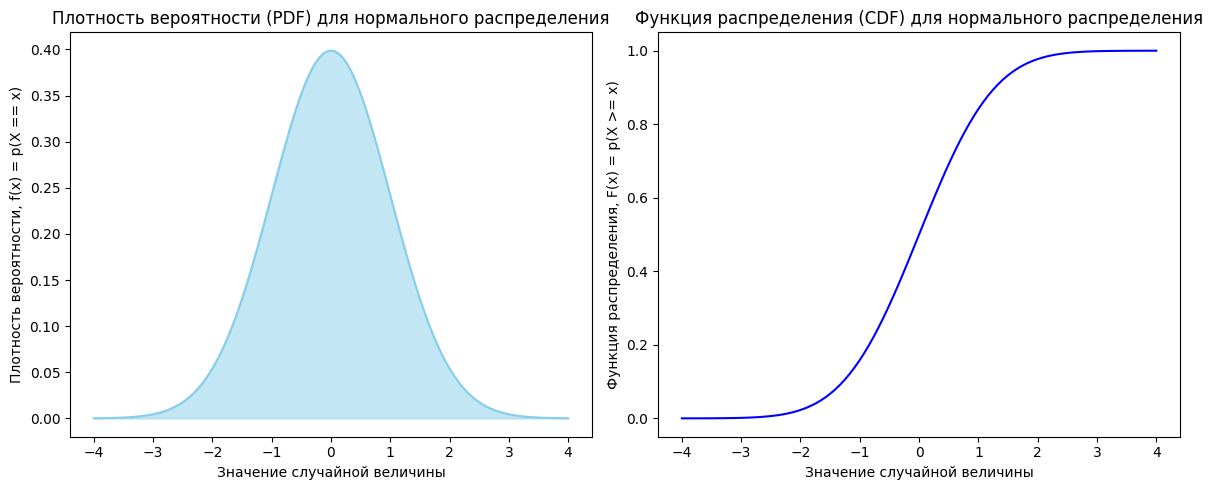

In [72]:
# Параметры нормального распределения
mean, std_dev = 0, 1  # среднее и стандартное отклонение
x = np.linspace(-4, 4, 100)  # значения по оси x

# Вычисляем PDF и CDF
normal_pdf = stats.norm.pdf(x, mean, std_dev)
normal_cdf = stats.norm.cdf(x, mean, std_dev)

# Создаем подграфики
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 5))

# Подграфик 1: PDF
ax1.plot(x, normal_pdf, color="skyblue")
ax1.fill_between(x, normal_pdf, color="skyblue", alpha=0.5)
ax1.set_title("Плотность вероятности (PDF) для нормального распределения")
ax1.set_xlabel("Значение случайной величины")
ax1.set_ylabel("Плотность вероятности, f(x) = p(X == x)")

# Подграфик 2: CDF
ax2.plot(x, normal_cdf, color="blue")
ax2.set_title("Функция распределения (CDF) для нормального распределения")
ax2.set_xlabel("Значение случайной величины")
ax2.set_ylabel("Функция распределения, F(x) = p(X >= x)")

# Отображаем графики
plt.tight_layout()
plt.show()

In [73]:
# пример генерации семпла в нужном распределении
stats.norm(mean, std_dev).rvs(10)

array([ 1.19992693,  0.87744819,  0.95590658,  1.79089133,  0.11725833,
       -0.28478694, -1.17484414, -0.52813928,  2.18735169,  0.54732011])

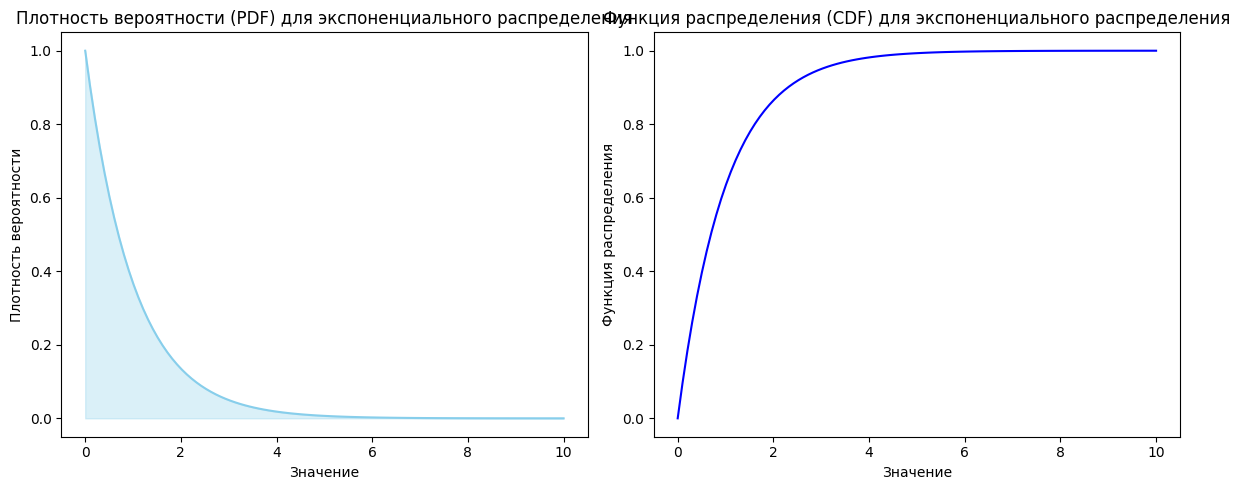

In [74]:
from scipy.stats import expon

# Параметры экспоненциального распределения
scale = 1  # параметр масштаба (обратная величина интенсивности λ)
x = np.linspace(0, 10, 100)  # значения по оси x

# Вычисляем PDF и CDF
expon_pdf = expon.pdf(x, scale=scale)
expon_cdf = expon.cdf(x, scale=scale)

# Создаем подграфики
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 5))

# Подграфик 1: PDF
ax1.plot(x, expon_pdf, color="skyblue")
ax1.fill_between(x, expon_pdf, color="skyblue", alpha=0.3)
ax1.set_title("Плотность вероятности (PDF) для экспоненциального распределения")
ax1.set_xlabel("Значение")
ax1.set_ylabel("Плотность вероятности")

# Подграфик 2: CDF
ax2.plot(x, expon_cdf, color="blue")
ax2.set_title("Функция распределения (CDF) для экспоненциального распределения")
ax2.set_xlabel("Значение")
ax2.set_ylabel("Функция распределения")

# Отображаем графики
plt.tight_layout()
plt.show()

In [75]:
# пример генерации семпла в нужном распределении
stats.expon(scale).rvs(10)

array([1.01083966, 1.03251153, 1.32863801, 2.79633765, 1.51012044,
       1.77140629, 6.2730968 , 1.12906904, 1.72835605, 2.04565228])

Дополнительно, если возникнут вдруг сложности в осознании базовых механизмов – рекомендую обратиться к материалам открытого курса по статистике в Академии Аналитиков Авито. 
- ноутбук по введению в статистику, где супер подробно разбирается биномиальный критерий https://github.com/avito-tech/applied_statistics/blob/main/Stats%20Intro.ipynb
- лендинг курса https://avito.tech/education/statistics

Ну и задавайте вопросы нам, конечно!